In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
import glob
from scipy.interpolate import make_smoothing_spline
linewidth = 2
markersize = 10

In [2]:
# Plotting util funcions
def percentage_formatter_x(x, pos):
    return f'{x:.0f}%'

def percentage_formatter_y(x, pos):
    return f'{100*x:.0f}%'

def format_legend_label(alpha):
            return f'$\\alpha$ = {alpha:.1f}'

# Reproduce Figure 2  - right plot
##  Example for perfect surrogate

Plot results from theory2D.py (perfect surrogate) and isotropic_lr.py (empirical results) for the right plot of 
Figure 2.

Plot misclassification error for logistic regression after non-reweighted subsampling, cf. Eq. 6.1 under  misspecified 
model $\mathbb P\big(y=1\big|z\big) := f(z)$, where $z = <\mathbf \theta_0, \mathbf x>$. Circles are results of numerical simulations, and continuous lines are theoretical predictions. Colors represent different values of the exponent $\alpha$ in Eq. 6.1. We reproduce and provide points for right plot (left can be reproduced using provided code): $N=6870$, $p=3000$. Each panel corresponds to a different choice of $f$, $\lambda$. 

In [12]:
## Provide paths for theory and empirical results
th_save_path = 'results/theoryResults2d' # results from theory2D.py
emp_save_path = 'results/syntheticResults' # results from isotropic_lr.py

In [13]:
 ## Read theory folder
all_files = glob.glob(os.path.join(th_save_path, "*.csv"))

theory_df_all = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
theory_df_all.rename(columns = {'LogLoss': 'log_loss', 'MiscError': 'mis_error', 'omegaExponent': 'omega_exponent'}, 
                     inplace=True)

theory_df_all['delta0'] = theory_df_all['dataN'] / theory_df_all['dataP'] 
theory_df_all['delta0'] = theory_df_all['delta0'].round(2)
theory_df_all['alpha_perp'] = theory_df_all['alpha_perp'].abs()

print(f"TOTAL : {len(theory_df_all)}")
print(f"CONVERGED : {len(theory_df_all.loc[np.isfinite(theory_df_all['alpha_perp'])])}")
print(f"DIVERGED : {len(theory_df_all.loc[~np.isfinite(theory_df_all['alpha_perp'])])}")

theory_df_all = theory_df_all.loc[np.isfinite(theory_df_all['alpha_perp'])]

TOTAL : 330
CONVERGED : 330
DIVERGED : 0


In [17]:
## Plot specific data points in the dataframe

# Data params
N_train = 6870
dataP = 3000
dataThetaNorm = 5
model_list = ['misspec', 'misspec2']
label_a = 0.95
label_b = 0.05

# LR params
lambd_list = [0.1, 0.01, 0.001]
reweight = False

# surrogate params (note: for this plot we have perfect surrogates)
N_surr = 0
lambd_surr = None

# subselection params
alphas = [-1, -0.5, 0, 0.5, 1]

# loss function to plot
loss = 'mis_error'

# method params
method = 'Trapez'
nq = 50

# interpolation params
spline_reg = 50
n_points_spline = 100

# empirical results
N_sim = 10

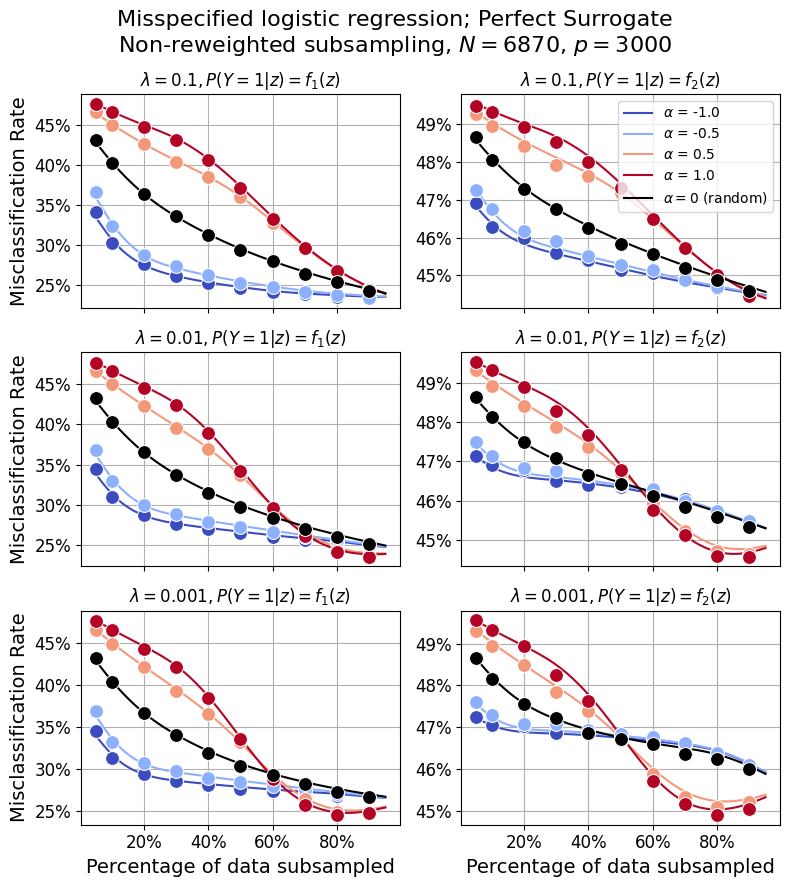

In [20]:
## Plot the figures
        
fig, axes = plt.subplots(len(lambd_list), len(model_list), figsize=(8, 9), sharex=True)
fig.subplots_adjust(hspace=0.2, top=0.93, wspace=0.18)
pal =sns.color_palette("coolwarm", as_cmap=True)

for j, misspec  in  enumerate(model_list):
    # Read synthetic simulation data
    sim_filename = (f'syntheticData_SnR-{dataThetaNorm}_P{dataP}_method-{misspec}_reweight-{reweight}'
                    f'_a-{label_a}_b-{label_b}_N_train-{N_train}' 
                    f'_Nsurr-{N_surr}_lambd_surr-{lambd_surr}_{N_sim}sim.csv')
    savePath = os.path.join(emp_save_path, sim_filename)

    sim_df = pd.read_csv(savePath)
    sim_df = sim_df.loc[~sim_df['alpha_exp'].isin(['Easy', 'Hard'])]
    sim_df.drop(['surr_score', 'lambd_surr'], axis=1, inplace=True)
    sim_df = sim_df.dropna()
    sim_df['alpha_exp'] = sim_df['alpha_exp'].astype(float)
    sim_df.rename(columns = {'log_loss_test': 'log_loss', 'mis_error_test': 'mis_error'}, inplace=True)
    
    for i, lambd in enumerate(lambd_list):
        ax = axes[i, j]
        sim_plot = sim_df.loc[sim_df['alpha_exp'].isin(alphas) &
                              (sim_df['lambd'] == lambd)]
        
        # Filter the theory df 
        theory_plot = theory_df_all.loc[(theory_df_all['alpha_exp'].isin(alphas)) &  
                                        (theory_df_all['method'] == method) & 
                                        (theory_df_all['label_method_a'] == label_a) & 
                                        (theory_df_all['label_method_b'] == label_b ) & 
                                        (theory_df_all['lambd'] == lambd ) &
                                        (theory_df_all['label_method'] == misspec) &
                                        (theory_df_all['dataP'] == dataP)]
        # Interpolate the theory points
        theory_plot_spline = []
        for alpha in alphas:
            sp = theory_plot.loc[theory_plot['alpha_exp'] == alpha]
            # Sort the DataFrame based on the value column
            sp = sp.sort_values(by='n_quadrature')
            sp = sp.drop_duplicates(subset='split_pct', keep='last').set_index('split_pct')[loss].sort_index()
            if len(sp)<6: # else not enough points to make meaningful interpolation 
                continue
            spline = make_smoothing_spline(sp.index,sp.values,lam = spline_reg )
            x_spline = np.linspace(sp.index.min(), sp.index.max(), n_points_spline)
            y_spline = spline(x_spline)
            
            temp_df = pd.DataFrame({'alpha_exp': len(x_spline)*[alpha], 'split_pct': x_spline, loss: y_spline})
            theory_plot_spline.append(temp_df)
            
        theory_plot = pd.concat(theory_plot_spline)
        
        # Plot the theory for non-zero alpha  
        sns.lineplot(data=theory_plot.loc[theory_plot['alpha_exp']!=0], x="split_pct", y=loss, ax=ax, 
                     linestyle='-', hue='alpha_exp', palette = pal)
        # Plot the theory for random sampling
        sns.lineplot(data=theory_plot.loc[theory_plot['alpha_exp']==0], x="split_pct", y=loss, ax=ax,
                     linestyle='-', color='black',label='$\\alpha = 0$ (random)')
        # Plot the simulations for non-zero alpha 
        sns.lineplot(data=sim_plot.loc[sim_plot['alpha_exp']!=0], x="split_pct", y=loss, 
                     err_style="bars", errorbar = ("se", 0), ax=ax, marker='o', 
                     markersize=markersize, hue='alpha_exp', linewidth = linewidth,
                     palette = pal, legend=False, alpha=1, linestyle='', estimator='median')
        # Plot the simulations for random sampling
        sns.lineplot(data=sim_plot.loc[sim_plot['alpha_exp']==0], x="split_pct", y=loss, 
                     err_style="bars", errorbar = ("se", 0), ax=ax, marker='o', markersize=markersize, 
                     color='black', legend = False, alpha=1, linewidth = linewidth, linestyle='', estimator='median')

        ax.legend().set_visible(False)

        # Customize legend labels using the mapping
        handles, labels = ax.get_legend_handles_labels()
        custom_labels = [format_legend_label(float(label)) if '.' in label else label for label in labels]

        ax.set_title(f"$\lambda = {lambd}, P(Y=1|z) = f_{j+1}(z)$" )

        if  i==0 and j==1:
            ax.legend(handles=handles, labels=custom_labels, fontsize=10).set_visible(True)
        if i!=2:
            ax.set_xlabel('')  
        else:
            ax.set_xlabel('Percentage of data subsampled', fontsize = 14)
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(percentage_formatter_x))
            ax.tick_params(axis='x', which='major', labelsize=12)

        ax.yaxis.set_major_formatter(ticker.FuncFormatter(percentage_formatter_y)) 
        ax.set_ylabel('Misclassification Rate', fontsize = 14)

        if j!=0:
            ax.set_ylabel('') 
        ax.tick_params(axis='y', which='major', labelsize=12)
        
        ax.grid()
        
title = f'Misspecified logistic regression; Perfect Surrogate\n' \
        f'Non-reweighted subsampling, $N=6870$, $p=3000$'

plt.suptitle(title, fontsize=16)
plt.tight_layout()
plt.show()

# Reproduce Figure 7 - bottom plot
## Example for imperfect surrogate model

Plot results from theory3D.py (imperfect surrogate) and isotropic_lr.py (empirical results) for the bottom plot of 
Figure 7.

Misclassification error for logistic regression  after non-reweighted subsampling with data generated according to the misspecified model $f_1(z)$ of previous plot. Circles: simulations. Continuous lines: theory. Here $N=34345$, $p=932$.
Unlike in previous figure, we now use an imperfect surrogate $\hat{\boldsymbol{\theta}}^{\mbox{\tiny\rm su}}$ that is
 fit on $N_{su}=8p$ samples from the same distribution. The values of $\lambda$ indicated in the plot titles are used
  when learning on the selected subsample.

In [21]:
## Provide paths for theory and empirical results
th_save_path = 'results/theoryResults3d' # results from theory3D.py
emp_save_path = 'results/syntheticResults' # results from isotropic_lr.py

In [22]:
## Read theory folder
all_files = glob.glob(os.path.join(th_save_path, "*.csv"))

theory_df_all = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
theory_df_all.rename(columns = {'LogLoss':'log_loss', 'MiscError':'mis_error', 'omegaExponent':'omega_exponent'}, inplace=True)

theory_df_all['delta0'] = theory_df_all['dataN'] / theory_df_all['dataP'] 
theory_df_all['delta0'] = theory_df_all['delta0'].round(2)
theory_df_all['alpha_perp'] = theory_df_all['alpha_perp'].abs()
theory_df_all['alpha_exp'] = theory_df_all['alphaExp']
theory_df_all['mis_error'] = theory_df_all['misc_error']
theory_df_all = theory_df_all.loc[np.isfinite(theory_df_all['alpha_perp'])]

print(f"TOTAL : {len(theory_df_all)}")
print(f"CONVERGED : {len(theory_df_all.loc[np.isfinite(theory_df_all['alpha_perp'])])}")
print(f"DIVERGED : {len(theory_df_all.loc[~np.isfinite(theory_df_all['alpha_perp'])])}")


TOTAL : 165
CONVERGED : 165
DIVERGED : 0


In [23]:
## Plot specific data points in the dataframe

# Data params
N_train = 34345
dataP = 932
dataThetaNorm = 5
model = 'misspec'
label_a = 0.95
label_b = 0.05

# LR params
lambd_list = [0.1, 0.01, 0.001]
reweight = False

# surrogate params (note: for this plot we have perfect surrogates)
N_surr = 8 * dataP # 8*p = 7456
lambd_surr = 0.01
 
## corresponding values of beta_0 and beta_perp to the chosen surrogate model
beta_perp = 0.95
beta_0 = 2.75


# subselection params
alphas = [-1, -0.5, 0, 0.5, 1]

# loss function to plot
loss = 'mis_error'

# method params
method = 'Trapez'
nq = 50

# interpolation params
spline_reg = 50
n_points_spline = 100

# empirical results
N_sim = 10

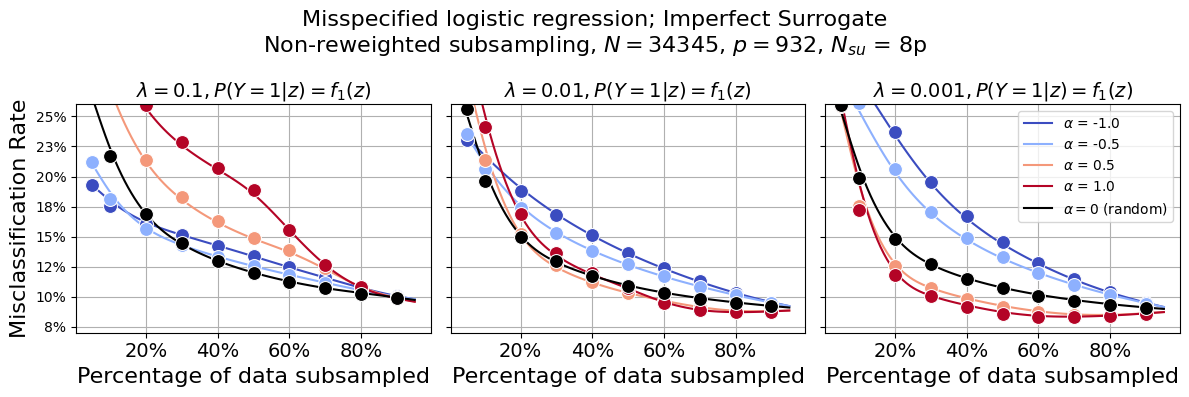

In [25]:
fig, axes = plt.subplots(1, len(lambd_list), figsize=(12, 4), sharey='row', sharex=True)
fig.subplots_adjust(wspace=0.1, top=0.93,hspace=0.2)
pal = sns.color_palette("coolwarm", as_cmap=True)

for i,lambd in enumerate(lambd_list):
    ax = axes[i]

    # Read synthetic simulation data
    sim_filename = (f'syntheticData_SnR-{dataThetaNorm}_P{dataP}_method-{model}_reweight-{reweight}'
                    f'_a-{label_a}_b-{label_b}_N_train-{N_train}' 
                    f'_Nsurr-{N_surr}_lambd_surr-{lambd_surr}_{N_sim}sim.csv')
    savePath = os.path.join(emp_save_path, sim_filename)    
    
    sim_df = pd.read_csv(savePath)
    sim_df['alpha_exp'] = sim_df['alpha_exp'].astype(float)
    sim_df.rename(columns = {'log_loss_test': 'log_loss', 'mis_error_test': 'mis_error'}, inplace=True)
    sim_plot = sim_df.loc[sim_df['alpha_exp'].isin(alphas) &
                         (sim_df['lambd'] == lambd )]
    # Read theory
    theory_plot = theory_df_all.loc[theory_df_all['alpha_exp'].isin(alphas) & 
                                    (theory_df_all['method'] == method) & 
                                    (theory_df_all['label_method_a'] == label_a ) & 
                                    (theory_df_all['label_method_b'] == label_b ) & 
                                    (theory_df_all['lambd'] == lambd ) &
                                    (theory_df_all['label_method'] == model) &
                                    (theory_df_all['beta_0'] == beta_0) &
                                    (theory_df_all['beta_perp'] == beta_perp) &
                                    (theory_df_all['dataThetaNorm']==dataThetaNorm) &
                                    (theory_df_all['dataP'] == dataP)
                                    ]
    theory_plot = theory_plot.reset_index(drop=True)
    theory_plot = theory_plot.loc[theory_plot.groupby(['alpha_exp', 'split_pct'])['n_quadrature'].idxmax()].reset_index(drop=True)
    # Interpolate the theory 
    theory_plot_spline = []
    for alpha in alphas:
        sp = theory_plot.loc[theory_plot['alpha_exp'] == alpha]
        sp = sp.sort_values(by='n_quadrature')
        sp = sp.drop_duplicates(subset='split_pct', keep='last').set_index('split_pct')[loss].sort_index()

        if len(sp)<6:
            continue
        spline = make_smoothing_spline(sp.index,sp.values,lam = spline_reg )
        x_spline = np.linspace(sp.index.min(), sp.index.max(), n_points_spline)
        y_spline = spline(x_spline)
        temp_df = pd.DataFrame({'alpha_exp': len(x_spline)*[alpha], 
                               'split_pct': x_spline,
                               loss: y_spline})
        theory_plot_spline.append(temp_df)

    theory_plot = pd.concat(theory_plot_spline)
    
    # Plot the theory for non-zero alpha 
    sns.lineplot(data=theory_plot.loc[theory_plot['alpha_exp']!=0], x="split_pct", y=loss, ax=ax, 
         linestyle='-', hue='alpha_exp', palette=pal)
    # Plot the theory for random sampling
    sns.lineplot(data=theory_plot.loc[theory_plot['alpha_exp']==0], x="split_pct", y=loss, ax=ax, 
                linestyle='-', color='black',label='$\\alpha = 0$ (random)')
    # Plot the simulations for non-zero alpha 
    sns.lineplot(data=sim_plot.loc[sim_plot['alpha_exp']!=0], x="split_pct", y=loss, 
                 err_style="bars", errorbar = ("se", 0), ax=ax, marker='o', 
                 markersize=markersize, hue='alpha_exp', linewidth = linewidth,
                 palette = pal, legend=False, alpha=1, linestyle='', estimator='median')
    # Plot the simulations for random sampling
    sns.lineplot(data=sim_plot.loc[sim_plot['alpha_exp']==0], x="split_pct", y=loss, 
                 err_style="bars", errorbar = ("se", 0), ax=ax, marker='o', markersize=markersize, 
                 color='black', legend = False, alpha=1, linewidth = linewidth, linestyle='', estimator='median')

    ax.set_xlabel('%Sampled', fontsize = 15)
    ax.set_ylabel(loss, fontsize = 15)
    ax.legend().set_visible(False)


    ax.grid()
    ax.set_title(f"$\lambda = {lambd}, P(Y=1|z) = f_1(z)$", fontsize=14)
    if i==2:
        handles, labels = ax.get_legend_handles_labels()
        custom_labels = [format_legend_label(float(label)) if '.' in label else label for label in labels]
        ax.legend(handles=handles, labels=custom_labels, fontsize=10).set_visible(True)

    ax.set_xlabel('Percentage of data subsampled', fontsize = 16)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(percentage_formatter_x))
    ax.tick_params(axis='x', which='major', labelsize=14)
    
    if i!=0:
        ax.set_ylabel('')  
    else:
        ax.set_ylim(bottom=0.07, top= 0.26)
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(percentage_formatter_y)) 
        ax.set_ylabel('Misclassification Rate', fontsize = 16)
        
title = f'Misspecified logistic regression; Imperfect Surrogate\n' \
        f'Non-reweighted subsampling, $N=34345$, $p=932$, $N_{{su}}$ = {N_surr // dataP}p'

plt.suptitle(title, fontsize=16)
plt.tight_layout()

plt.show()